## This LSTM network entails 9 features and is LSTM single output RNN

#*1st* step : load all the necessary libraries and upload the data and parse it correctly

In [ ]:
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
print(tf.__version__)

1.14.0


In [ ]:
#import all libraries
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

In [ ]:
#import our file
from google.colab import files
uploaded = files.upload()

Saving data_eng_2015-2020.csv to data_eng_2015-2020 (3).csv


In [ ]:
#load our first data set for 2007-2009 and parse dates so pandas can recognize it
#include dayfirst so we get the right date format for graphs and the rest of the time series
#Update the string name when you change the data to be loaded
import io
df = pd.read_csv(io.BytesIO(uploaded['data_eng_2015-2020.csv']), parse_dates=True, dayfirst=True,index_col='Date')

In [ ]:
df.head()

,SP500,SP500_open,SP500_high,SP500_low,US10Y,US5Y,VIX,INF_10Y,Bollinger_Upper,Bollinger_Lower
Date,,,,,,,,,,
2015-12-09,2047.62,2061.17,2080.33,2036.53,2.268,1.694,19.610001,1.54,2114.087627,2033.819373
2015-12-10,2052.23,2047.93,2067.65,2045.67,2.287,1.737,19.340000,1.55,2113.667379,2030.691621
2015-12-11,2012.37,2047.27,2047.27,2008.80,2.238,1.721,24.389999,1.56,2113.885224,2027.971776
2015-12-14,2021.94,2013.37,2022.92,1993.26,2.199,1.676,22.730000,1.53,2118.221580,2020.508420
2015-12-15,2043.41,2025.55,2053.87,2025.55,2.197,1.666,20.950001,1.50,2117.707864,2021.369136


# Step 2 : Exploratory Data Analysis

##Create a correlation matrix

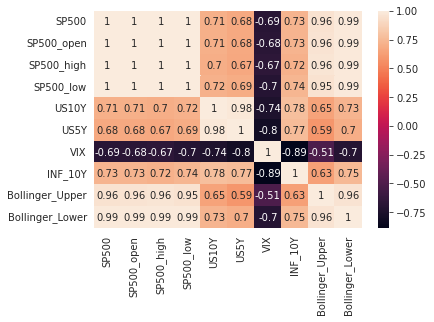

In [ ]:
#correlation matrix
import seaborn as sn
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

##Plot all the features

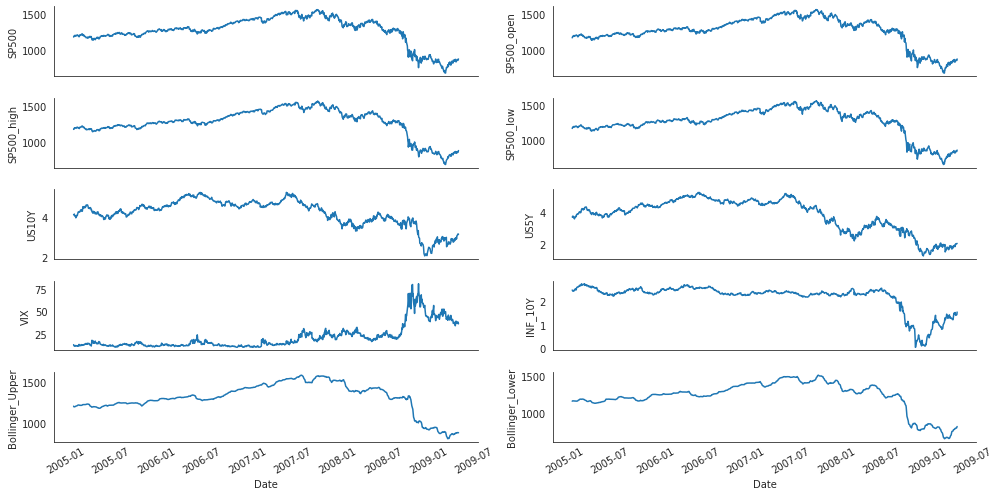

In [ ]:
#Explore the data
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

#Step 3: Rescaling the data
## Create the training data frame

In [ ]:
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['SP500','SP500_high', 'SP500_low', 'SP500_open', 'VIX', 'US10Y','US5Y','INF_10Y','Bollinger_Lower','Bollinger_Upper']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
#We add the prediction column to help us with the predictions on the SP500 column later
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SP500']


# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['SP500', 'SP500_high', 'SP500_low', 'SP500_open', 'VIX', 'US10Y', 'US5Y', 'INF_10Y', 'Bollinger_Lower', 'Bollinger_Upper']


,SP500,SP500_high,SP500_low,SP500_open,VIX,US10Y,US5Y,INF_10Y,Bollinger_Lower,Bollinger_Upper,Prediction
Date,,,,,,,,,,,
2020-03-05,3023.94,3083.04,2999.83,3075.70,39.619999,0.951,0.717,1.14,2925.394017,3552.360983,3023.94
2020-03-06,2972.37,2985.93,2901.54,2954.20,41.939999,0.728,0.492,1.17,2885.636728,3553.046272,2972.37
2020-03-09,2746.56,2863.89,2734.43,2863.89,54.459999,0.997,0.650,1.19,2831.377578,3560.140422,2746.56
2020-03-10,2882.23,2882.59,2734.00,2813.48,47.299999,1.266,0.820,1.23,2773.408294,3567.629706,2882.23
2020-03-11,2741.38,2825.60,2707.22,2825.60,53.900002,1.119,0.648,1.26,2729.215275,3557.795725,2741.38


## Rescaling and shaping the data with MinMaxScaler



In [ ]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SP500'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1070, 10)


## Splitting our training and test data
##Validating our split by checking that the last value is equal to the predicted one

In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("SP500")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 8 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(806, 50, 10) (806,)
(214, 50, 10) (214,)
0.059207357408465944
0.059207357408465944


#Step 4: Compiling and Training the LSTM Model

## Model  Description

An LSTM layer, which takes our mini-batches as input and returns the whole sequence

Another LSTM layer that takes the sequence from the previous layer but only returns five values

Dense layer with five neurons

A final dense layer that outputs the predicted value

## Evaluate the model performance

In [ ]:
from matplotlib.cbook import flatten
# Configure the neural network model
model = Sequential()

# Configure the Neural Network Model with n Neurons - inputshape = t Timestamps x f Features
n_neurons = x_train.shape[1] * x_train.shape[2]
print('timesteps: ' + str(x_train.shape[1]) + ',' + ' features:' + str(x_train.shape[2]))
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=True))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(64))
model.add(Dense(1, activation='relu'))


# Configure the Model   
optimizer='adam'; loss='mean_squared_error'; epochs = 50; batch_size = 32; patience = 8; 

# Set learning rate to standard, 0.05
learn_rate = 0.001

parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer) + ' with learn rate ' + str(learn_rate), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))



timesteps: 50, features:10
Parameters: ['epochs 50', 'batch_size 32', 'patience 8', 'optimizer adam with learn rate 0.001', 'loss mean_squared_error']


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 500)           1022000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 500)           2002000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32064     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,058,129
Trainable params: 5,058,129
Non-trainable params: 0
_________________________________________________________________


##Variable importance

In [ ]:
# Compile and Training the model
model.compile(optimizer=optimizer, loss=loss)
early_stop = EarlyStopping(monitor='loss', patience=patience, verbose=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stop], shuffle = True,validation_data=(x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 806 samples, validate on 214 samples
Epoch 1/50
806/806 [==============================] - 108s 135ms/sample - loss: 0.1906 - val_loss: 0.0321
Epoch 2/50
806/806 [==============================] - 108s 134ms/sample - loss: 0.0063 - val_loss: 0.0049
Epoch 3/50
806/806 [==============================] - 105s 130ms/sample - loss: 0.0012 - val_loss: 0.0073
Epoch 4/50
806/806 [==============================] - 105s 130ms/sample - loss: 9.6865e-04 - val_loss: 0.0043
Epoch 5/50
806/806 [==============================] - 107s 133ms/sample - loss: 8.7797e-04 - val_loss: 0.0028
Epoch 6/50
806/806 [==============================] - 104s 129ms/sample - loss: 7.7237e-04 - val_loss: 0.0022
Epoch 7/50
806/806 [==============================] - 103s 128ms/sample - loss: 6.6059e-04 - val_loss: 0.0019
Epoch 8/50
806/806 [==============================] - 110s 137ms/sample - loss: 7.1641e-04 - val_loss: 0.0033
Epoch 9/50
806/806 [==============================] - 104s 129ms/sample - loss: 7.6858

#Step 5: Plot loss function to validate the training

The loss drops quickly to a plateau, showing that the model has improved throughout the training process

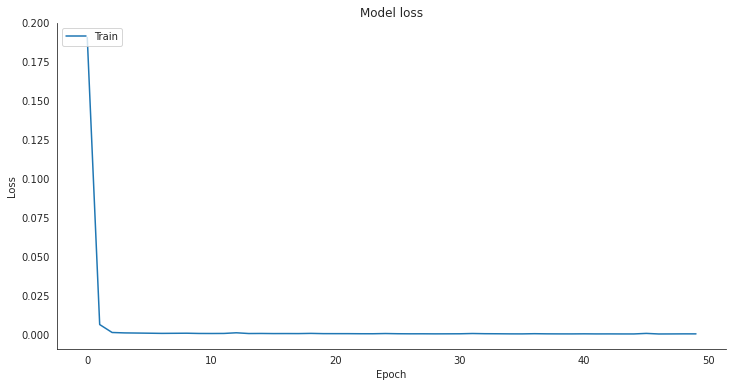

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.xticks([0,10,20,30,40,50])
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

#Step 6: Evaluate the model
##We compile several metrics: MSE, MAPE and MDAPE

In [ ]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 52.97
Mean Absolute Percentage Error (MAPE): 1.72 %
Median Absolute Percentage Error (MDAPE): 1.33 %


#Step 7 : Visualising the training, test and prediction data

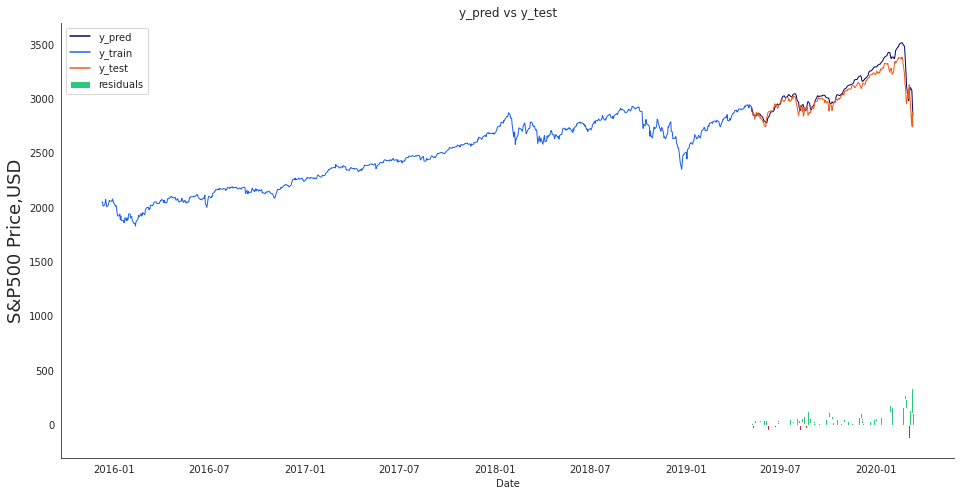

In [ ]:
# The date from which on the date is displayed
display_start_date = "2015-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['SP500'][:train_data_len + 1]).rename(columns={'SP500': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['SP500'][train_data_len:]).rename(columns={'SP500': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel('S&P500 Price,USD', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

#Step 8: Predict the next day trading price for the S&P 500

In [ ]:
#Input last day for the df
end_date = ('11/03/2020')

df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['SP500'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for SP500 at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

The close price for SP500 at 11/03/2020 was 2741.38
The predicted close price is 2767.080078125 (+0.93%)


#Understand the impact of each feature on each sequence for the prediction

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 2.1 MB/s 


In [ ]:
import shap


In [ ]:
# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model, x_train[:500])
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_test)
# init the JS visualization code
shap.initjs()

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], FEATURES)

In [ ]:
shap_values_2D = shap_values[0].reshape(-1,10)
X_test_2D = x_test.reshape(-1,10)


shap_values_2D.shape, X_test_2D.shape

((9630, 10), (9630, 10))

In [ ]:
x_test_2d = pd.DataFrame(data=X_test_2D, columns = FEATURES)

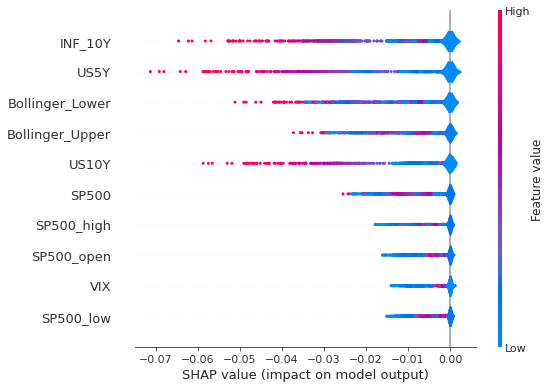

In [ ]:
shap.initjs()
shap.summary_plot(shap_values_2D, x_test_2d,plot_type="violin")
